In [4]:
import collections
# Prepare paths to local utilities
import os
import sys

import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [5]:

utils_path = os.path.abspath(os.path.join('..', 'model'))
sys.path.append(utils_path)

%load_ext autoreload
%autoreload 2

In [6]:
from reservoir.BasicESN import BasicESN as BasicESN


In [7]:
#For testing, we will use a version of the mackey-glass time series, as this only contains one feature so it is easier to work with as a first test
# This function is based on the mackey_glass implementation in the reservoirpy library
#https://github.com/reservoirpy/reservoirpy/blob/master/reservoirpy/datasets/_chaos.py
# (Accessed 10/07/2024)
def mackey_glass(timesteps, tau=17, a = 0.2, b = 0.1, n = 10, x0 = 1.2, h = 1.0, seed = None):
    '''
    Generate the Mackey-Glass time series
    :param timesteps: The number of timesteps to generate
    :param tau: Time delay tau
    :param a: The a parameter
    :param b: The b parameter
    :param n: The n parameter
    :param x0: The initial condition
    :param h: Time delta between timesteps
    :param seed: Random seed
    :return: The Mackey-Glass time series
    '''
    
    # Set the seed
    if seed is not None:
        np.random.seed(seed)
        
    # Initialize the time series
    x = np.zeros(timesteps)
    
    # Set the initial condition
    history_length = int(np.floor(tau / h))
    history = collections.deque(
        x0 * np.ones(history_length) + 0.2 * (np.random.rand(history_length) - 0.5),
    )
    
    xi = x0
    
    # Generate the time series
    for i in range(0, timesteps):
        x[i] = xi
        
        if tau == 0:
            xtau = 0.0
        else:
            xtau = history.popleft()
            history.append(xi)
            
        def f(xi, xtau, a, b, n, h=1.0):
            return -b * xi + a * xtau / (1 + xtau**n)
            
        # Discretise the next value using the Runge-Kutta method
        k1 = h * f(xi, xtau, a, b, n)
        k2 = h * f(xi + 0.5 * k1, xtau, a, b, n)
        k3 = h * f(xi + 0.5 * k2, xtau, a, b, n)
        k4 = h * f(xi + k3, xtau, a, b, n)
        
        xi = xi + k1 / 6 + k2 / 3 + k3 / 3 + k4 / 6

    return x.reshape(-1, 1)

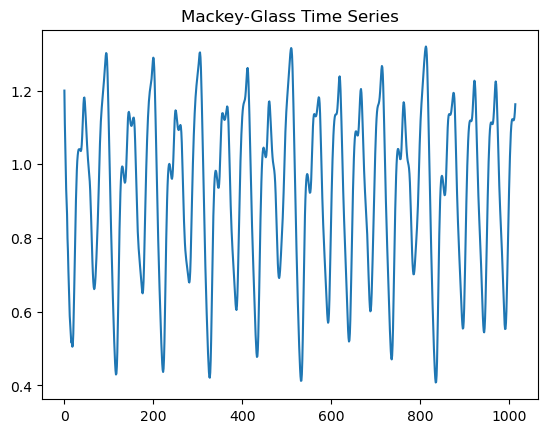

In [8]:
# Generate the time series
prediction_steps = 15
timesteps = 1000 + prediction_steps
series = mackey_glass(timesteps)

# Plot the time series
plt.figure()
plt.plot(series)
plt.title('Mackey-Glass Time Series')
plt.show()

Input shape: (1000, 1)
Output shape: (1000, 1)


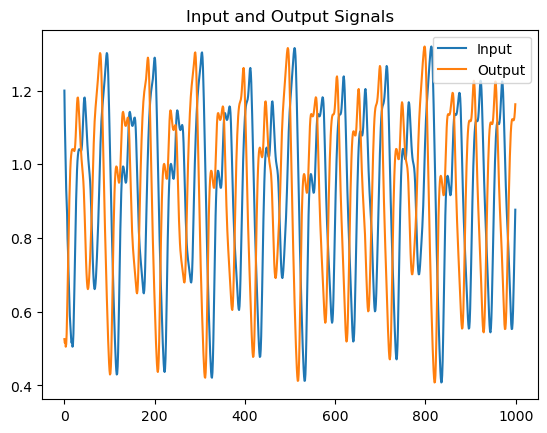

In [9]:
# Our output signal is the same as the input signal, but shifted by n timesteps
output = np.roll(series, -prediction_steps, axis=0)

# Trim the last n timesteps from the input signal
input = series[:timesteps - prediction_steps]

# Do the same with the output signal
output = output[:timesteps - prediction_steps]

# Print the shape of the input and output signals
print('Input shape:', input.shape)
print('Output shape:', output.shape)

# Plot the input and output signals
plt.figure()
plt.plot(input, label='Input')
plt.plot(output, label='Output')
plt.title('Input and Output Signals')
plt.legend()
plt.show()


In [10]:
# Next, we need to generate the input weights for the ESN
# To do this, we will create a matrix of shape (n_neurons, n_features) where n_neurons is the number of neurons in the reservoir and n_features is the number of features in the input signal
# We will then populate this matrix from a density function where elements are 1 for a value p, and 0 for a value of 1-p
# This will give us a sparse matrix with a density of p

# Set the density of the input weights
density = 0.5

n_features = input.shape[1]
n_neurons = 100

# Generate the input weights
input_weights = np.random.rand(n_neurons, n_features) < density

# Print the shape of the input weights
print('Input weights shape:', input_weights.shape)

# Print the input weights
print('Input weights:')
print(input_weights)

Input weights shape: (100, 1)
Input weights:
[[ True]
 [False]
 [False]
 [ True]
 [ True]
 [False]
 [ True]
 [ True]
 [ True]
 [False]
 [False]
 [ True]
 [False]
 [False]
 [ True]
 [False]
 [ True]
 [ True]
 [False]
 [False]
 [ True]
 [False]
 [False]
 [ True]
 [False]
 [ True]
 [ True]
 [ True]
 [False]
 [ True]
 [ True]
 [False]
 [False]
 [ True]
 [ True]
 [ True]
 [ True]
 [False]
 [False]
 [False]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [False]
 [False]
 [False]
 [ True]
 [False]
 [False]
 [False]
 [ True]
 [ True]
 [False]
 [False]
 [False]
 [ True]
 [False]
 [ True]
 [False]
 [ True]
 [ True]
 [ True]
 [ True]
 [False]
 [False]
 [ True]
 [ True]
 [False]
 [False]
 [False]
 [ True]
 [ True]
 [False]
 [False]
 [ True]
 [ True]
 [False]
 [False]
 [ True]
 [ True]
 [False]
 [False]
 [False]
 [ True]
 [ True]
 [ True]
 [ True]
 [False]
 [ True]
 [ True]
 [False]
 [False]
 [False]
 [ True]
 [False]
 [ True]
 [False]
 [False]]


In [11]:
# Next, we initialise the ESN
# We will use the BasicESN class from the reservoir.BasicESN module

leakage_rate = 0.3
spectral_radius = 0.9
gamma = 1.0
W_in = input_weights

esn = BasicESN(leakage_rate=leakage_rate, spectral_radius=spectral_radius, gamma=gamma, n_neurons=n_neurons, W_in=W_in)

In [12]:
# Next, we will train the ESN. We can do this by calling the fit method of the ESN and passing the input and output signals as arguments
esn.fit(input, output)

Predictions shape: (1000, 1)


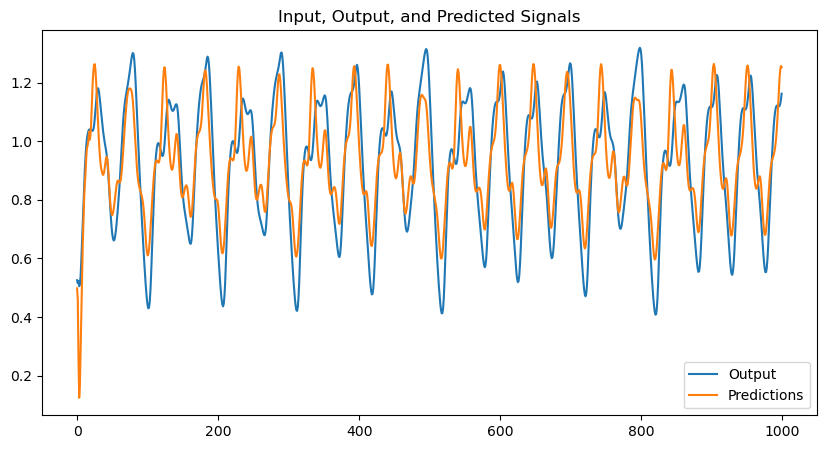

In [13]:
# Next, we will use the ESN to make predictions on the input signal
# We can do this by calling the predict method of the ESN and passing the input signal as an argument
predictions = esn.forward(input)

# Print the shape of the predictions
print('Predictions shape:', predictions.shape)

# Plot the input, output, and predicted signals
plt.figure(figsize=(10, 5))
#plt.plot(input, label='Input')
plt.plot(output, label='Output')
plt.plot(predictions, label='Predictions')
plt.title('Input, Output, and Predicted Signals')
plt.legend()
plt.show()


State history shape: (1000, 100)


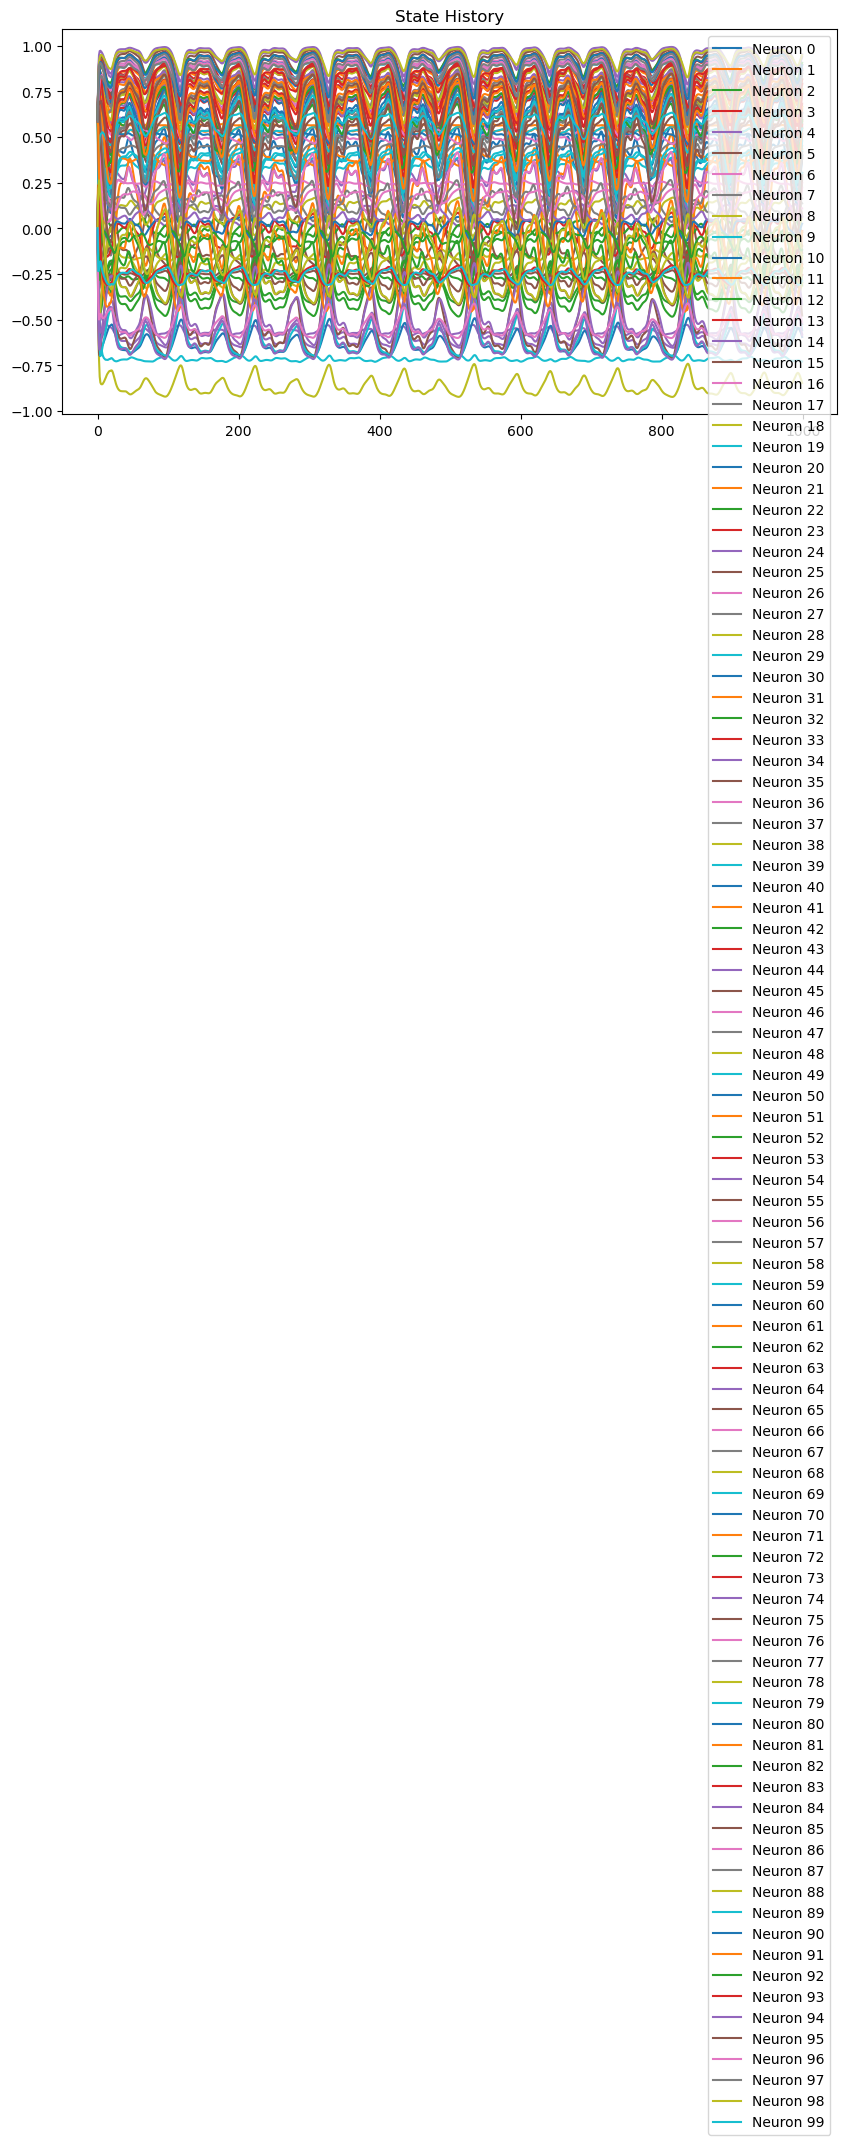

In [14]:
# Lets check the state of the reservoir over time
# We can do this by calling the get_state_history method of the ESN
# This will return a matrix of shape (n_timesteps, n_neurons) where n_timesteps is the number of timesteps in the input signal
state_history = esn.get_state_history()

# Print the shape of the state history
print('State history shape:', state_history.shape)

# Plot the state history
plt.figure(figsize=(10, 5))

for i in range(n_neurons):
    plt.plot(state_history[:, i], label='Neuron {}'.format(i))
    
plt.title('State History')
plt.legend()
plt.show()


In [15]:
# Next, we will evaluate the performance of the ESN by calculating the normalised root mean squared error (NRMSE) between the output and predicted signals

def nrmse(y_true, y_pred):
    '''
    Calculate the normalised root mean squared error (NRMSE)
    :param y_true: The true values
    :param y_pred: The predicted values
    :return: The NRMSE
    '''
    return np.sqrt(np.mean((y_true - y_pred) ** 2)) / (np.max(y_true) - np.min(y_true))

# Calculate the NRMSE
nrmse_value = nrmse(output, predictions)

# Print the NRMSE
print('NRMSE:', nrmse_value)

NRMSE: 0.13940163945997489


In [16]:
# Now that we have an error metric, we can use this to tune the hyperparameters of the ESN
# We can do this by creating a grid of hyperparameters and evaluating the performance of the ESN on each combination of hyperparameters

# Define the hyperparameters to tune
leakage_rates = np.arange(0.1, 1.0, 0.1)
spectral_radii = np.arange(0.1, 1.0, 0.1)
gammas = np.arange(0.1, 1.0, 0.1)
n_neuronss = [10, 50, 100, 200]
densities = np.arange(0.1, 1.0, 0.1)

# Create a grid of hyperparameters
hyperparameters = []

for leakage_rate in leakage_rates:
    for spectral_radius in spectral_radii:
        for gamma in gammas:
            for n_neurons in n_neuronss:
                for density in densities:
                    hyperparameters.append({
                        'leakage_rate': leakage_rate,
                        'spectral_radius': spectral_radius,
                        'gamma': gamma,
                        'n_neurons': n_neurons,
                        'density': density
                    })
                    
# Print the number of hyperparameter combinations
print('Number of hyperparameter combinations:', len(hyperparameters))


Number of hyperparameter combinations: 26244


In [18]:
# Next, we will evaluate the performance of the ESN on each combination of hyperparameters using a grid search
# We will store the results in a dictionary where the key is the hyperparameters and the value is the NRMSE

# Create a dictionary to store the results
results = {}

# There are a lot of combinations, as this is quite a quick training process, lets parallelise this
import joblib
from joblib import Parallel, delayed
from tqdm import tqdm
import contextlib

@contextlib.contextmanager
def tqdm_joblib(tqdm_object):
    '''
    Context manager to patch joblib to report into tqdm progress bar given as argument
    :param tqdm_object: The tqdm progress bar
    '''
    class TqdmBatchCompletionCallback(joblib.parallel.BatchCompletionCallBack):

        def __call__(self, *args, **kwargs):
            tqdm_object.update(n=self.batch_size)
            return super().__call__(*args, **kwargs)

    old_batch_callback = joblib.parallel.BatchCompletionCallBack
    joblib.parallel.BatchCompletionCallBack = TqdmBatchCompletionCallback

    try:
        yield tqdm_object
    finally:
        joblib.parallel.BatchCompletionCallBack = old_batch_callback
        tqdm_object.close()


# Define a function to evaluate the ESN on a given set of hyperparameters
def evaluate_esn(hyperparameter, input, output):
    try:
        # Generate the input weights
        input_weights = np.random.rand(hyperparameter['n_neurons'], n_features) < hyperparameter['density']
        
        # Create the ESN
        esn = BasicESN(leakage_rate=hyperparameter['leakage_rate'], spectral_radius=hyperparameter['spectral_radius'], gamma=hyperparameter['gamma'], n_neurons=hyperparameter['n_neurons'], W_in=input_weights)
        
        # Train the ESN
        esn.fit(input, output)
        
        # Make predictions
        predictions = esn.forward(input)
        
        # Calculate the NRMSE
        nrmse_value = nrmse(output, predictions)
        
        # Return the hyperparameters and NRMSE
        return {'hyperparameter': hyperparameter, 'nrmse': nrmse_value}
    except Exception as e:
        print('Error:', e)

# Evaluate the ESN on each combination of hyperparameters
# Create an arguments list
args = [{'hyperparameter': hyperparameter, 'input': np.copy(input), 'output': np.copy(output)} for hyperparameter in hyperparameters]

# Evaluate the ESN on each combination of hyperparameters
with tqdm_joblib(tqdm(desc="Hyperparameters", total=len(args))) as progress_bar:
    results = Parallel(n_jobs=-1)(delayed(evaluate_esn)(arg['hyperparameter'], arg['input'], arg['output']) for arg in args)

# # Store the results in a dictionary
results = {str(result['hyperparameter']): result['nrmse'] for result in results}

# Print the results
print('Results:', results)


# Loop over each combination of hyperparameters
# for i, hyperparameter in enumerate(hyperparameters):
#     # Print the current hyperparameters
#     print('Hyperparameters:', hyperparameter)
#     
#     # Generate the input weights
#     input_weights = np.random.rand(hyperparameter['n_neurons'], n_features) < hyperparameter['density']
#     
#     # Create the ESN
#     esn = BasicESN(leakage_rate=hyperparameter['leakage_rate'], spectral_radius=hyperparameter['spectral_radius'], gamma=hyperparameter['gamma'], n_neurons=hyperparameter['n_neurons'], W_in=input_weights)
#     
#     # Train the ESN
#     esn.fit(input, output)
#     
#     # Make predictions
#     predictions = esn.forward(input)
#     
#     # Calculate the NRMSE
#     nrmse_value = nrmse(output, predictions)
#     
#     # Store the results
#     results[str(hyperparameter)] = nrmse_value
#     
#     # Print the NRMSE
#     print('NRMSE:', nrmse_value)
#     
#     # Print the progress
#     print('Progress:', (i + 1) / len(hyperparameters) * 100, '%')
    
# Print the results
# print('Results:', results)

Hyperparameters: 100%|██████████| 26244/26244 [1:10:32<00:00,  6.20it/s]
IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [21]:
# Next, we will find the hyperparameters that give the best performance
# We can do this by finding the hyperparameters with the lowest
# NRMSE in the results dictionary

# Find the hyperparameters with the lowest NRMSE
best_hyperparameters = min(results, key=results.get)

# Print the best hyperparameters
print('Best hyperparameters:', best_hyperparameters)

# Print the NRMSE of the best hyperparameters
print('Best NRMSE:', results[best_hyperparameters])

Best hyperparameters: {'leakage_rate': 0.7000000000000001, 'spectral_radius': 0.9, 'gamma': 0.9, 'n_neurons': 200, 'density': 0.6}
Best NRMSE: 0.051149580020684836


NRMSE: 0.07402100972269085


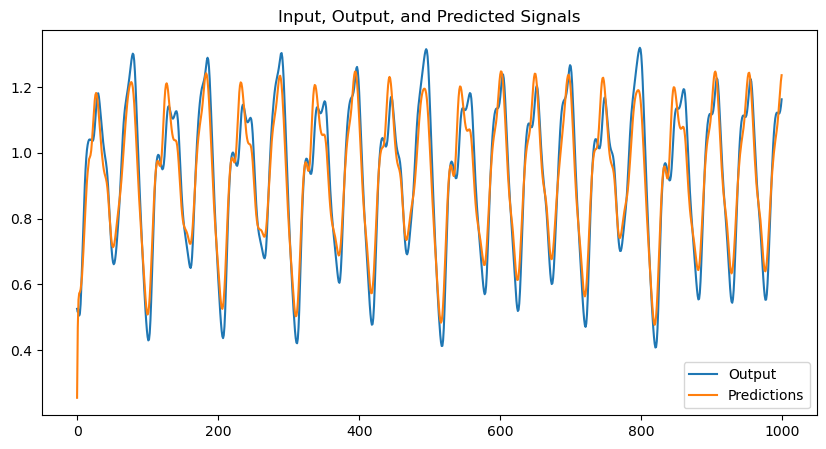

In [22]:
# Next, we will use the best hyperparameters to create a new ESN
# We will then train the ESN on the input and output signals
# and make predictions

# Get the best hyperparameters
best_hyperparameters = eval(best_hyperparameters)

# Generate the input weights
input_weights = np.random.rand(best_hyperparameters['n_neurons'], n_features) < best_hyperparameters['density']

# Create the ESN
esn = BasicESN(leakage_rate=best_hyperparameters['leakage_rate'], spectral_radius=best_hyperparameters['spectral_radius'], gamma=best_hyperparameters['gamma'], n_neurons=best_hyperparameters['n_neurons'], W_in=input_weights)

# Train the ESN
esn.fit(input, output)

# Make predictions
predictions = esn.forward(input)

# Calculate the NRMSE
nrmse_value = nrmse(output, predictions)

# Print the NRMSE
print('NRMSE:', nrmse_value)

# Plot the input, output, and predicted signals
plt.figure(figsize=(10, 5))
#plt.plot(input, label='Input')
plt.plot(output, label='Output')
plt.plot(predictions, label='Predictions')
plt.title('Input, Output, and Predicted Signals')
plt.legend()
plt.show()

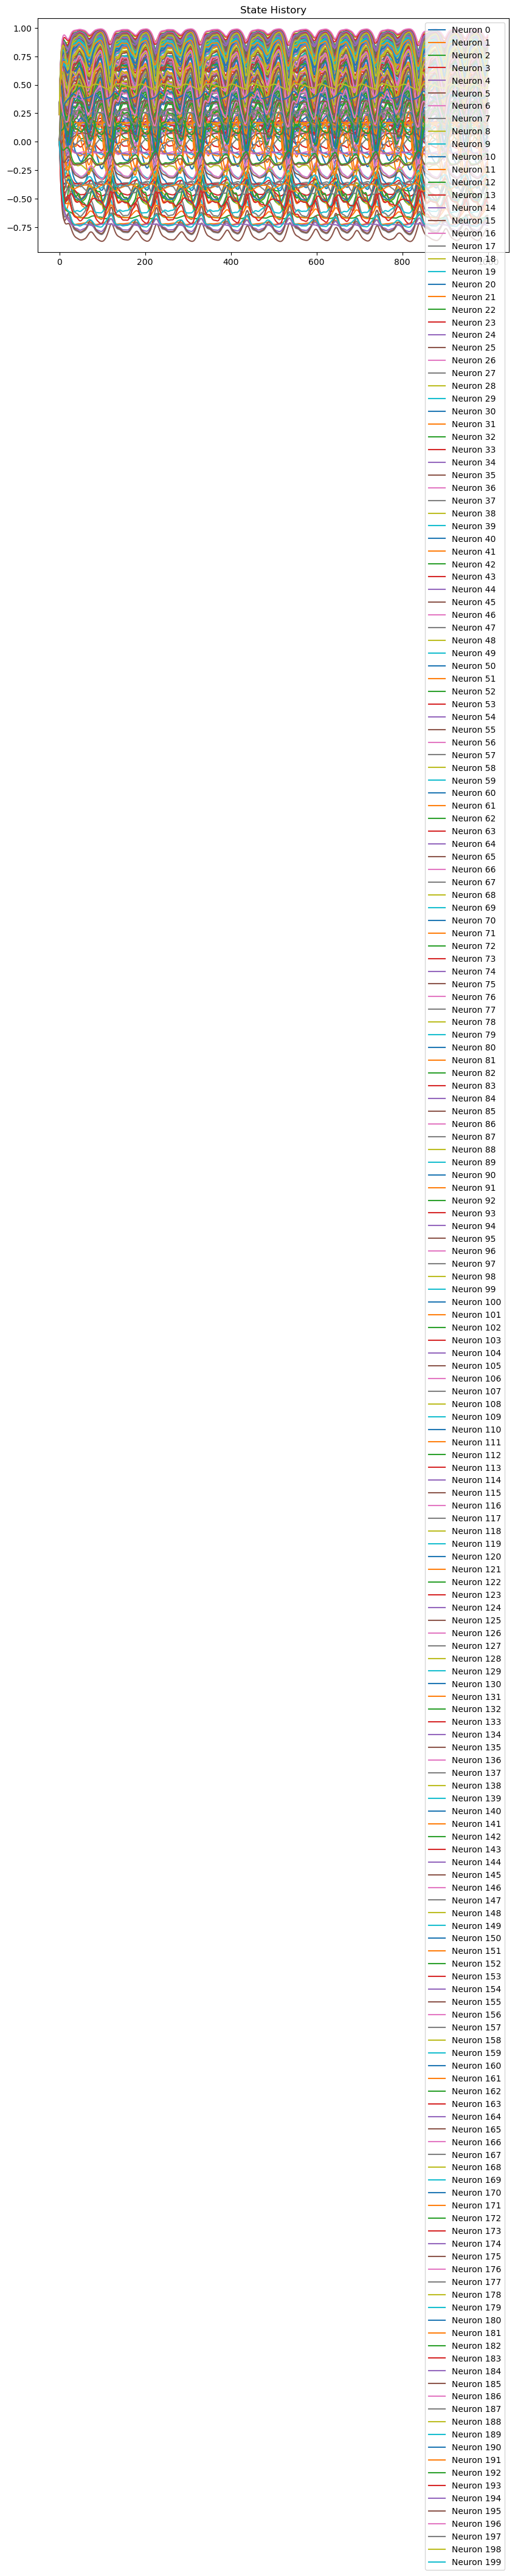

In [23]:
# Display the neuron responses
state_history = esn.get_state_history()

# Plot the state history
plt.figure(figsize=(10, 5))

for i in range(n_neurons):
    plt.plot(state_history[:, i], label='Neuron {}'.format(i))
    
plt.title('State History')
plt.legend()
plt.show()


NRMSE Test: 1.9579389379242849


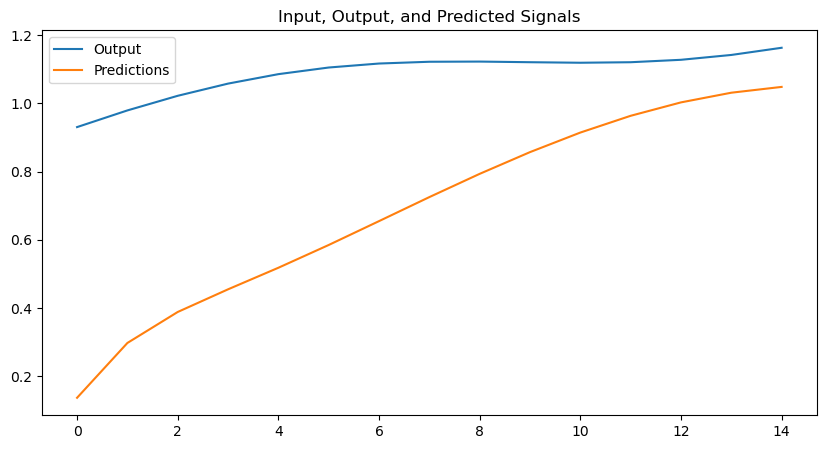

In [24]:
# To sanity check the ability of the model, lets try to predict the next 15 steps
# We will use the last 15 steps of the input signal as the input to the model
# and compare the output to the true output

# Get the last 15 steps of the input signal
input_test = input[-prediction_steps:]

# Get the true output
output_test = output[-prediction_steps:]

# Make predictions
predictions_test = esn.forward(input_test)

# Calculate the NRMSE
nrmse_value_test = nrmse(output_test, predictions_test)

# Print the NRMSE
print('NRMSE Test:', nrmse_value_test)

# Plot the input, output, and predicted signals
plt.figure(figsize=(10, 5))
#plt.plot(input_test, label='Input')
plt.plot(output_test, label='Output')
plt.plot(predictions_test, label='Predictions')
plt.title('Input, Output, and Predicted Signals')
plt.legend()
plt.show()


Input shape: (1000, 1)
Output shape: (1000, 1)


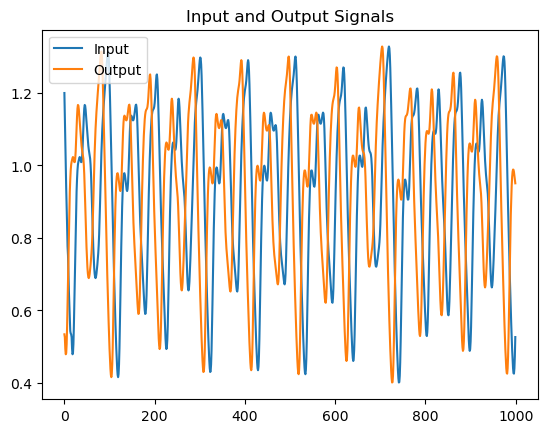

NRMSE: 0.07332935417817275


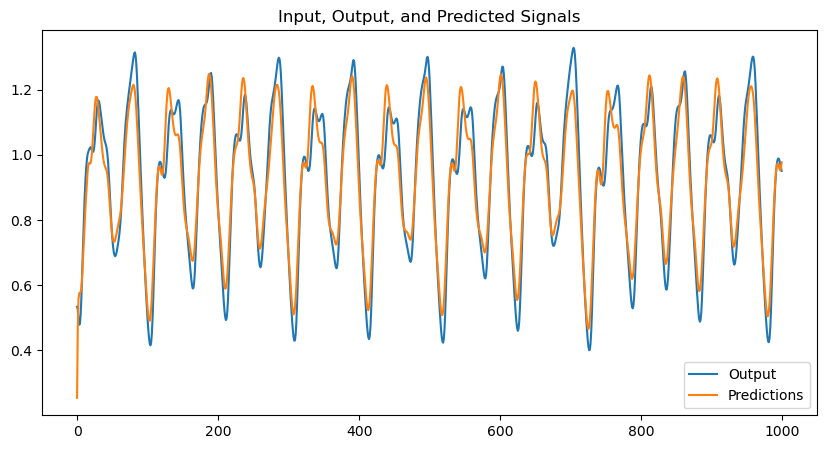

In [25]:
# Lets try generating a new input signal and see how well the model can predict it
# Generate the time series
prediction_steps = 15
timesteps = 1000 + prediction_steps
series = mackey_glass(timesteps)

# Our output signal is the same as the input signal, but shifted by n timesteps
output = np.roll(series, -prediction_steps, axis=0)

# Trim the last n timesteps from the input signal
input = series[:timesteps - prediction_steps]

# Do the same with the output signal
output = output[:timesteps - prediction_steps]

# Print the shape of the input and output signals
print('Input shape:', input.shape)
print('Output shape:', output.shape)

# Plot the input and output signals
plt.figure()
plt.plot(input, label='Input')
plt.plot(output, label='Output')
plt.title('Input and Output Signals')
plt.legend()
plt.show()

# Make predictions
predictions = esn.forward(input)

# Calculate the NRMSE
nrmse_value = nrmse(output, predictions)

# Print the NRMSE
print('NRMSE:', nrmse_value)

# Plot the input, output, and predicted signals
plt.figure(figsize=(10, 5))
#plt.plot(input, label='Input')
plt.plot(output, label='Output')
plt.plot(predictions, label='Predictions')
plt.title('Input, Output, and Predicted Signals')
plt.legend()
plt.show()


In [ ]:
# The predicted signal is quite close to the true signal, this is a good result and shows that the ESN is able to learn the underlying dynamics of the Mackey-Glass time series

In [26]:
# Let's pickle the model for later use
import pickle

with open('basicESN_mackeyglass.pkl', 'wb') as f:
    pickle.dump(esn, f)